In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

import warnings
warnings.filterwarnings('ignore')

In [3]:
# URL https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-03-05 09:44:40--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.78.216.154, 2600:1417:8000:9ac::e59, 2600:1417:8000:980::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.78.216.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  75.6MB/s    in 11s     

2021-03-05 09:44:52 (69.8 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [5]:
# Use os.makedirs to create your directories
try:
    os.makedirs('/tmp/cats-v-dogs/train/cats/')
    os.makedirs('/tmp/cats-v-dogs/train/dogs/')
    os.makedirs('/tmp/cats-v-dogs/valid/cats/')
    os.makedirs('/tmp/cats-v-dogs/valid/dogs/')
except OSError:
    pass

In [6]:
# os.listdir(DIRECTORY) gives a listing of the contents of that directory
# os.path.getsize(PATH) gives the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    list_of_files = os.listdir(SOURCE)
    shuffled_files = random.sample(list_of_files, len(list_of_files))
    train_len = len(list_of_files) * SPLIT_SIZE
    for filename in list_of_files:
        if train_len > 1:
            if os.path.getsize(SOURCE + filename) > 0:
                copyfile(SOURCE + filename, TRAINING + filename)
                train_len -= 1
            else:
                print(filename, ' is zero length, so ignoring')
        else:
            if os.path.getsize(SOURCE + filename) > 0:
                copyfile(SOURCE + filename, TESTING + filename)
            else:
                print(filename, ' is zero length, so ignoring')
        

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/train/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/valid/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/train/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/valid/dogs/"

split_size = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg  is zero length, so ignoring
11702.jpg  is zero length, so ignoring


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/train/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/train/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/valid/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/valid/dogs/')))

11250
11250
1250
1250


In [31]:
IMSIZE = 256

model = tf.keras.models.Sequential([
# layer 1
tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMSIZE, IMSIZE, 3)),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D((2,2)),
# layer 2
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D((3,3), strides=2),
# layer 3
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.BatchNormalization(),  
tf.keras.layers.MaxPool2D((2,2)),
# layer 4
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.BatchNormalization(),  
tf.keras.layers.MaxPool2D((2,2), strides=2),
# layer 5
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPool2D((2,2)),
# layer 6
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.BatchNormalization(),  
# classifier
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 60, 64)       

In [33]:
TRAINING_DIR = '/tmp/cats-v-dogs/train/'
train_datagen = ImageDataGenerator(
    rescale=1/255,
    #rotation_range = 40,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.2,
    #zoom_range = 0.2,
    #horizontal_flip = True
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMSIZE, IMSIZE), 
    class_mode='binary', 
    batch_size=50
) 
VALIDATION_DIR = '/tmp/cats-v-dogs/valid/'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMSIZE, IMSIZE),
    class_mode='binary',
    batch_size=50
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [34]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
450/450 [==============================] - 87s 193ms/step - loss: 0.5669 - accuracy: 0.7174 - val_loss: 0.8177 - val_accuracy: 0.6552
Epoch 2/15
450/450 [==============================] - 86s 192ms/step - loss: 0.3335 - accuracy: 0.8534 - val_loss: 0.4944 - val_accuracy: 0.7580
Epoch 3/15
450/450 [==============================] - 86s 192ms/step - loss: 0.2175 - accuracy: 0.9097 - val_loss: 0.2181 - val_accuracy: 0.9156
Epoch 4/15
450/450 [==============================] - 87s 192ms/step - loss: 0.1603 - accuracy: 0.9352 - val_loss: 0.2269 - val_accuracy: 0.8988
Epoch 5/15
450/450 [==============================] - 86s 192ms/step - loss: 0.1197 - accuracy: 0.9533 - val_loss: 0.3490 - val_accuracy: 0.8740
Epoch 6/15
450/450 [==============================] - 86s 192ms/step - loss: 0.1003 - accuracy: 0.9618 - val_loss: 0.3774 - val_accuracy: 0.8756
Epoch 7/15
450/450 [==============================] - 86s 192ms/step - loss: 0.0745 - accuracy: 0.9719 - val_loss: 0.1935 - val_ac

In [12]:
model.save('/tmp/model/cast_dogs.h5')

Text(0.5, 1.0, 'Training and validation loss')

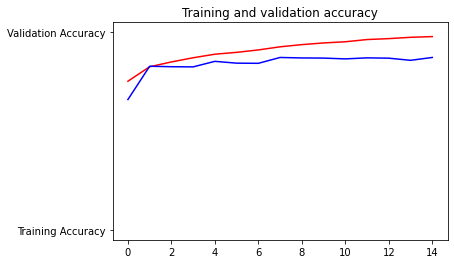

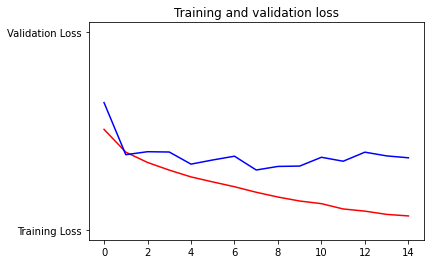

In [24]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')

In [56]:
# upload and classify images

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMSIZE, IMSIZE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving rhodesian-ridgeback-2727035_640.jpg to rhodesian-ridgeback-2727035_640.jpg
Saving maltese-1123016_640.jpg to maltese-1123016_640.jpg
Saving tiger-3264048_640.jpg to tiger-3264048_640.jpg
Saving cat-551554_640.jpg to cat-551554_640.jpg
Saving cat-694730_640.jpg to cat-694730_640.jpg
[1.]
rhodesian-ridgeback-2727035_640.jpg is a dog
[1.]
maltese-1123016_640.jpg is a dog
[1.3709173e-21]
tiger-3264048_640.jpg is a cat
[0.]
cat-551554_640.jpg is a cat
[0.]
cat-694730_640.jpg is a cat
